# Images and Coordinates in Astronomy

In this lesson we are going to look at aspects of processing and viewing images specific to Astronomy and Solar Astronomy. By the end of this lesson you should understand:

* Projected Coordinate Systems in Images
* World Coordinate Systems
* Using WCS to calculate coordinates in images
* Plotting images with WCS in images
* Using SunPy Map

## Projected Coordinate Systems

When taking images of the sky, we are projecting the spherical celestial coordinate system onto a 2-dimensional plane, which means that there is no simple linear relation between pixel coordinates and celestial coordinates

There are multiple coordinate systems used to describe the locations in 2D and 3D space for both Astronomy and Solar Physics. We shall use a couple of these systems here as examples but if you want to know more about them there are many of resources avalible.

![Spherical Coordinates](coord_inset.png)


### Physical Coordinate Systems

Projected coordinate systems are one type of physical coordinate systems, they are the one we will be focusing on in this lesson due to their applicability to imaging data. Astropy and SunPy support representing point in many different physical coordinate systems, both projected and fully 3D, such as ICRS or Helioprojective.

In [1]:
import astropy.units as u
import sunpy.coordinates
from astropy.coordinates import SkyCoord

In [4]:
icrs = SkyCoord(10*u.deg,86*u.deg,frame="icrs")
icrs 

<SkyCoord (ICRS): (ra, dec) in deg
    (10., 86.)>

In [5]:
icrs.transform_to("galactic")

<SkyCoord (Galactic): (l, b) in deg
    (122.7151072, 23.13306851)>

In [7]:
hpc = SkyCoord(100*u.arcsec,700*u.arcsec,obstime="now",frame='helioprojective')
hpc

<SkyCoord (Helioprojective: obstime=2018-09-07 09:50:33.069821, rsun=695508.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2018-09-07 09:50:33.069821): (lon, lat, radius) in (deg, deg, AU)
    (0., 7.25031077, 1.00778204)>): (Tx, Ty) in arcsec
    (100., 700.)>

In [8]:
hpc.transform_to("heliographic_stonyhurst")

<SkyCoord (HeliographicStonyhurst: obstime=2018-09-07 09:50:33.069821): (lon, lat, radius) in (deg, deg, km)
    (10.34722285, 54.31824854, 695508.0000023)>

In [9]:
hpc.transform_to("icrs")

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, km)
    (56.31639192, 44.30542203, 1232616.50837405)>

### World Coordinate System

#### From pixels  to physical coordinates

The FITS files have a standard for describing the physical coordinate system associated with imaging data, this is called the world coordinate system or WCS, sometimes the specific FITS version of this is referred to as FITS-WCS.

There are multiple papers describing the FITS-WCS standard for various types of data, there is a list here: http://fits.gsfc.nasa.gov/fits_wcs.html

As you learned in the previous lesson we can load FITS files with Astropy. To demonstrate a simple example of a FITS file with FITS-WCS information in the header we shall use an image from SunPy:

In [10]:
from sunpy.data.sample import AIA_171_IMAGE
from astropy.io import fits

In [11]:
AIA_171_IMAGE

'/Users/dannyhorta/sunpy/data/sample_data/AIA20110607_063302_0171_lowres.fits'

As you can see there are lots of keys in this and most other real world FITS headers. The ones we need to understand for FITS-WCS are:

In [12]:
hdulist = fits.open(AIA_171_IMAGE)
hdulist.verify("fix")
hdulist[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
BLD_VERS= 'V5R12X  '                                                            
LVL_NUM =                  1.5                                                  
T_REC   = '2011-06-07T06:33:03Z'                                                
TRECSTEP=                  1.0                                                  
TRECEPOC= '1977.01.01_00:00:00_TAI'                                             
TRECROUN=                    1                                                  
ORIGIN  = 'SDO     '                                                            
DATE    = '2012-10-16T19:45:

In [13]:
hdulist.info()

Filename: /Users/dannyhorta/sunpy/data/sample_data/AIA20110607_063302_0171_lowres.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     201   (1024, 1024)   float32   


Reference Pixel and Coordinate:

In [15]:
header = hdulist[0].header

print(header["CRVAL1"],header["CRVAL2"])
print(header["CRPIX1"],header["CRPIX2"])

3.223099507700556 1.385781353025793
512.5 512.5


Pixel resolution (at the reference pixel):

In [16]:
print(header["CDELT1"],header["CDELT2"])

2.402792 2.402792


Rotation angle, in degress (at the reference pixel):

In [17]:
print(header["CROTA2"])

-0.138829


Coordinate System and Projection:

In [19]:
print(header["CTYPE1"],header["CTYPE2"])

HPLN-TAN HPLT-TAN



<section class="challange panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> Keyword Extraction</h2>
</div>


<div class="panel-body">

<p>Extract and print out the <code>TELESCOP</code> value from the header.</p>
<p>Next, extract the <code>WAVELNTH</code> and <code>WAVEUNIT</code> values, use these to construct an astropy Quantity object for the wavelength of this image.</p>

</div>

</section>



<section class="solution panel panel-primary">
<div class="panel-heading">
<h2><span class="fa fa-eye"></span> Solution</h2>
</div>

</section>


In [21]:
print(header['TELESCOP'])

SDO


In [30]:
print(header['WAVELNTH'])
print(header['WAVEUNIT'])

u.Quantity(header["WAVELNTH"],header['WAVEUNIT'])

171
angstrom


<Quantity 171. Angstrom>

We could now sit down and work out how to convert from a pixel coordinate to a physical coordinate described by this header (Helioprojective).

However, we can cheat and just use Astropy.

In [31]:
from astropy.wcs import WCS

In [32]:
wcs = WCS(header)

In [33]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.00089530541880571  0.00038493926472938695  
CRPIX : 512.5  512.5  
NAXIS : 1024  1024

We can convert from pixel to world coordinate:

In [34]:
wcs.wcs_pix2world(100,100,0)   #(column,row,origin)

[array(359.72558028), array(-0.27359599)]

Or back again:

In [35]:
wcs.wcs_world2pix(359.72558028,-0.27359599,0)

[array(100.0000054), array(100.00000496)]

The last parameter to the two above examples is the 'origin' parameter. It is a flag that tells WCS if you indexes should be 0-based (like numpy) or 1-based (like FITS).
Here we are using 0 as we want to convert to and from numpy indexes of the array.

## Where are my Pixels?

```
[-500, 0]
[500, 500]
[0, 0]
```


<section class="solution panel panel-primary">
<div class="panel-heading">
<h2><span class="fa fa-eye"></span> Solution</h2>
</div>

</section>


In [36]:
wcs.wcs_pix2world(-500,0,0)

[array(359.32498365), array(-0.33934733)]

In [37]:
wcs.wcs_pix2world(500,500,0)

[array(359.99320114), array(-0.00727203)]

In [38]:
wcs.wcs_pix2world(0,0,0)

[array(359.65867648), array(-0.34017347)]

### WCS and SkyCoord

A common usecase for WCS + Coordinates is to store or transform from pixel coordinates to one or more different physical coordinates. Combining Astropy WCS and Coordinates makes this easy.

Assuming we have the WCS object we created from the FITS header above we can get an astropy Coordinate Frame:

In [39]:
from astropy.wcs.utils import wcs_to_celestial_frame

In [40]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.00089530541880571  0.00038493926472938695  
CRPIX : 512.5  512.5  
NAXIS : 1024  1024

In [42]:
hpc_frame = wcs_to_celestial_frame(wcs)
hpc_frame

<Helioprojective Frame (obstime=2011-06-07 06:33:02.770000, rsun=695508.0 km, observer=earth)>

We can then use this when creating `SkyCoord` objects:

In [44]:
c= SkyCoord(100*u.arcsec,-500*u.arcsec,frame=hpc_frame)
c.transform_to("galactic")

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, km)
    (318.62812121, 25.16820864, 1003066.07716878)>

In [45]:
SkyCoord.from_pixel(512,512, wcs=wcs)

<SkyCoord (Helioprojective: obstime=2011-06-07 06:33:02.770000, rsun=695508.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2011-06-07 06:33:02.770000): (lon, lat, radius) in (deg, deg, AU)
    (0., 0.03652003, 1.01484379)>): (Tx, Ty) in arcsec
    (4.42740299, 2.58426282)>

In [49]:
c.to_pixel(wcs)

(array(552.28234644), array(302.92977852))

*Note: For solar data you should always use `sunpy.map` for this*

## Coordinate Aware Plotting

In this section we are going to use the `astropy.visualization.wcsaxes` subpackage to make WCS aware image plots.

For this example we are going to use a Hubble image.

In [50]:
from astropy.io import fits

In [53]:
hdulist = fits.open('h_n4571_f555_mosaic.fits.gz')
hdulist.info()

Filename: h_n4571_f555_mosaic.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1151   (4096, 4096)   float32   


In [54]:
wcs = WCS(hdulist[0].header)
wcs   #world coordinate system

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 189.244985579  14.21241102505  
CRPIX : 1766.58499986649  1796.30099988174  
CD1_1 CD1_2  : -1.319036e-05  -4.095479e-06  
CD2_1 CD2_2  : -4.120773e-06  1.318951e-05  
NAXIS : 4096  4096

In [55]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


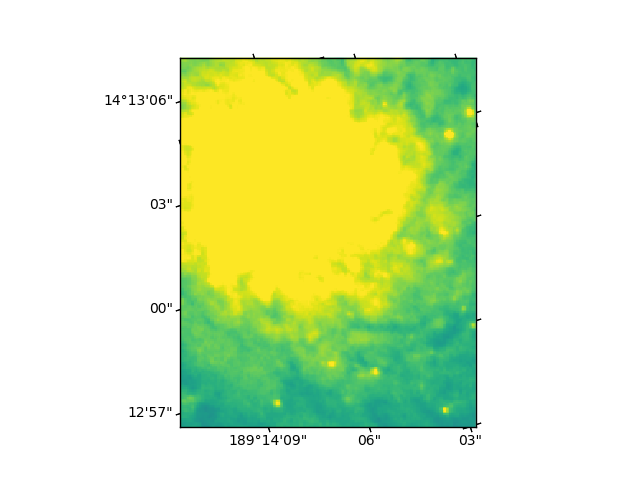

In [65]:
#ax = plt.subplot(projection='aitoff')
#ax = plt.subplot(projection='polar')

ax = plt.subplot(projection=wcs)   #normally has a projection=... keyword
ax.imshow(hdulist[0].data, vmax=1000, origin='lower')

This image now has physcial labels in the native coordinate system of the image. We can see what the coordinate system and projection of this image is using the 'CTYPE' header entries we saw earlier.

In [67]:
wcs.wcs.equinox

2000.0

We can tell that this is in the FK5 coordinate system by the presence of a 'equinox' entry in the header:


<section class="challange panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> Add some labels</h2>
</div>


<div class="panel-body">

<p>Now we have a nice plot with physically meaningful ticks, we should label our axes.</p>
<p>Add labels to the axes saying "Right Ascension [degrees]" and "Declination [degrees]"</p>
<p>Also overlay a coordinate grid using:
<code>ax.coords.grid()</code>
Look up the documentation for this method to see what parameters you can specify.</p>

</div>

</section>



<section class="solution panel panel-primary">
<div class="panel-heading">
<h2><span class="fa fa-eye"></span> Solution</h2>
</div>

</section>


<IPython.core.display.Javascript object>


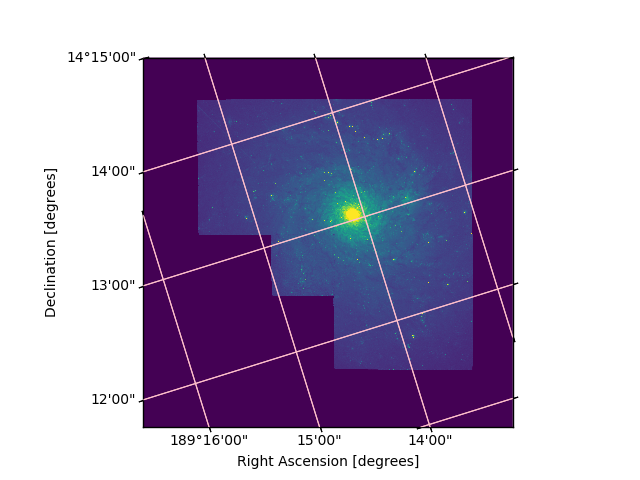

In [75]:
plt.figure()
ax = plt.subplot(projection=wcs)   #normally has a projection=... keyword
ax.imshow(hdulist[0].data, vmax=1000, origin='lower')
ax.coords.grid(hdulist[0].data,grid_type='contours',color='pink')
# plt.xlabel('Right Ascension[degrees]')
# plt.ylabel('Declination[degrees]')
# plt.show()
ax.set_xlabel('Right Ascension [degrees]')
ax.set_ylabel('Declination [degrees]')


Now we have a nice plot, we can do a couple of things to plot.

### Overplotting in Pixel Coordinates

<IPython.core.display.Javascript object>


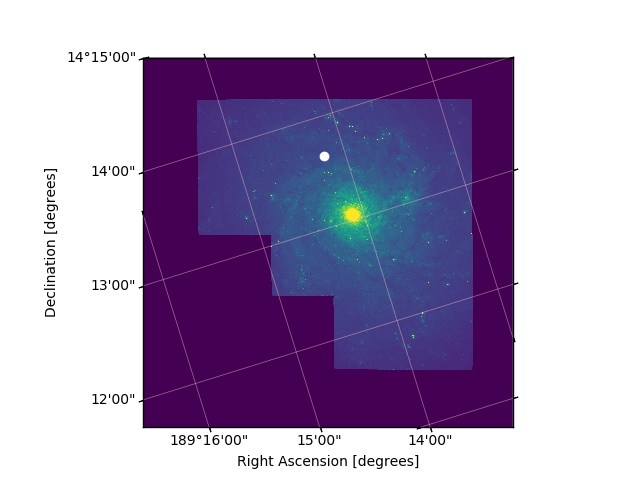

In [80]:
plt.figure()
ax = plt.subplot(projection=wcs)   #normally has a projection=... keyword
ax.imshow(hdulist[0].data, vmax=1000, origin='lower')
ax.coords.grid(hdulist[0].data,grid_type='contours',color='pink',alpha=0.3,linewidth=0.5)

ax.set_xlabel('Right Ascension [degrees]')
ax.set_ylabel('Declination [degrees]')
ax.plot(2000,3000,'o',color='white')

### Overplotting in World Coordinates

In [81]:
coord=SkyCoord(189.25*u.deg,14.23*u.deg,frame='fk5')

<IPython.core.display.Javascript object>


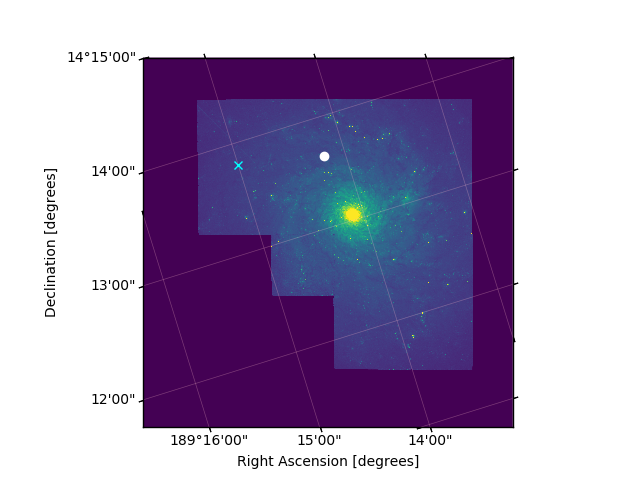

In [82]:
plt.figure()
ax = plt.subplot(projection=wcs)   #normally has a projection=... keyword
ax.imshow(hdulist[0].data, vmax=1000, origin='lower')
ax.coords.grid(hdulist[0].data,grid_type='contours',color='pink',alpha=0.3,linewidth=0.5)

ax.set_xlabel('Right Ascension [degrees]')
ax.set_ylabel('Declination [degrees]')
ax.plot(2000,3000,'o',color='white')
ax.plot_coord(coord,'x',color='cyan')


<section class="challange panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> Overplot in a different coordinate system</h2>
</div>


<div class="panel-body">

<p>Using <code>ax.get_transform()</code> you can specify coordinates in any system that astropy coordinates can transform to, try overplotting a point in the <code>'galactic'</code> system.</p>
<p>Also overlay a coordinate grid using:
<code>ax.coords.grid()</code>
Look up the <a href="http://wcsaxes.readthedocs.io/en/latest/overlaying_coordinate_systems.html">documentation</a> for this method to see what parameters you can specify.</p>

</div>

</section>


###  Overplotting Another Coordinate System

<IPython.core.display.Javascript object>


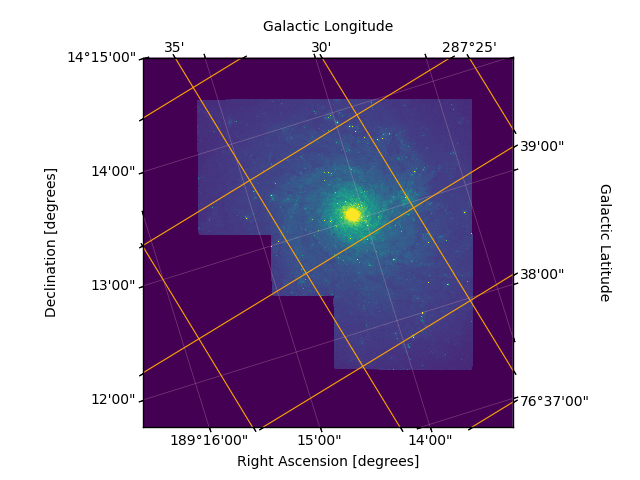

In [89]:
plt.figure()
ax = plt.subplot(projection=wcs)   #normally has a projection=... keyword
ax.imshow(hdulist[0].data, vmax=1000, origin='lower')
ax.coords.grid(hdulist[0].data,grid_type='contours',color='pink',alpha=0.3,linewidth=0.5)

ax.coords[0].set_axislabel('Right Ascension [degrees]')
ax.coords[1].set_axislabel('Declination [degrees]')

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='orange')
overlay[0].set_axislabel('Galactic Longitude')
overlay[1].set_axislabel('Galactic Latitude')

## SunPy Map

The SunPy Map class is a wrapper for solar images which makes some of the above opertations easier.

In [90]:
import sunpy.map
from sunpy.data.sample import AIA_171_ROLL_IMAGE

<IPython.core.display.Javascript object>


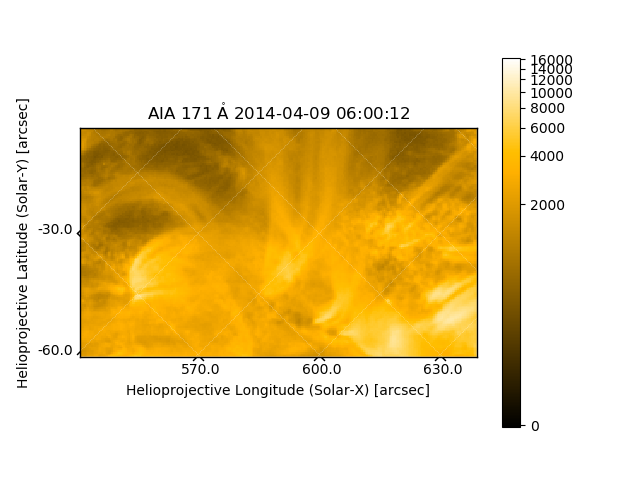

In [91]:
amap = sunpy.map.Map(AIA_171_ROLL_IMAGE)
amap.peek()

### Coordinate Systems

The SunPy map will calculate some of the things we did earlier automatically, and add some extra information.

In [92]:
amap.coordinate_system

SpatialPair(axis1='HPLN-TAN', axis2='HPLT-TAN')

In [93]:
amap.coordinate_frame

<Helioprojective Frame (obstime=2014-04-09 06:00:12.970000, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2014-04-09 06:00:12.970000): (lon, lat, radius) in (deg, deg, m)
    (0., -6.047074, 1.49860274e+11)>)>

In [94]:
amap.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.0  0.0  
CRPIX : 2053.459961  2047.880005  
PC1_1 PC1_2  : 0.7073447192241196  0.7068687630570128  
PC2_1 PC2_2  : -0.7068687630570128  0.7073447192241196  
CDELT : 0.599489  0.599489  
NAXIS : 0  0

### Plotting

SunPy map uses these attributes to do it's plotting with WCSAxes like we did manually earlier. We can therefore use the overplotting and grid techniques to improve the plot:

In [95]:
import astropy.units as u

<IPython.core.display.Javascript object>


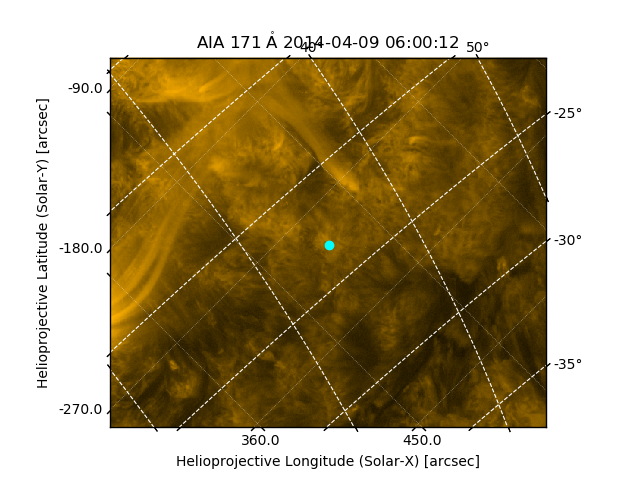

In [99]:
fid = plt.figure()

im= amap.plot()

ax = plt.gca() #gca gets current axis (finds the axis set up and does it as default setup)

ax.plot_coord(SkyCoord(500*u.arcsec,-300*u.arcsec,frame=amap.coordinate_frame),'o',color='cyan')

#amap.draw_grid()

overlay = ax.get_coords_overlay('heliographic_stonyhurst')
overlay.grid(color='white',alpha=1,linestyle='dashed')

In [103]:
sc=amap.pixel_to_world(100*u.pix,100*u.pix)
sc

<SkyCoord (Helioprojective: obstime=2014-04-09 06:00:12.970000, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2014-04-09 06:00:12.970000): (lon, lat, radius) in (deg, deg, m)
    (0., -6.047074, 1.49860274e+11)>): (Tx, Ty) in arcsec
    (-1652.90620495, 1.80900012)>

In [101]:
amap.world_to_pixel

<bound method GenericMap.world_to_pixel of SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 171.0 Angstrom
Wavelength:		 171.0 Angstrom
Observation Date:	 2014-04-09 06:00:12
Exposure Time:		 2.999649 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.599489 0.599489] arcsec / pix
Reference Pixel:	 [2053.459961 2047.880005] pix
Reference Coord:	 [0. 0.] arcsec
array([[-1,  1, -1, ..., -1, -1,  1],
       [-1, -1,  2, ...,  2, -1,  0],
       [ 1, -1,  0, ..., -1, -1, -1],
       ...,
       [ 0,  0, -1, ..., -3,  1,  2],
       [-1,  1,  0, ...,  2, -3,  0],
       [ 1, -1,  3, ...,  2,  1,  0]], dtype=int16)>

In [106]:
print(sc.Tx)
sc.Ty

-1652.91arcsec


<Latitude 1.80900012 arcsec>

In [107]:
amap.world_to_pixel(SkyCoord(10*u.deg,20*u.deg,frame='heliographic_stonyhurst'))

PixelPair(x=<Quantity 1741.54523091 pix>, y=<Quantity 2728.14124929 pix>)


<section class="challange panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> Rotate your Owl</h2>
</div>


<div class="panel-body">

<p>Why is the Sun wonky?</p>
<p>Use the <a href="http://docs.sunpy.org/en/stable/code_ref/map.html#sunpy.map.mapbase.GenericMap.rotate"><code>rotate()</code></a> method of SunPy Map to align the coordinate grid to the pixel grid in this sample image.</p>
<p>Once you have run rotate, plot the resulting image, and compare with the one above.</p>

</div>

</section>


<IPython.core.display.Javascript object>


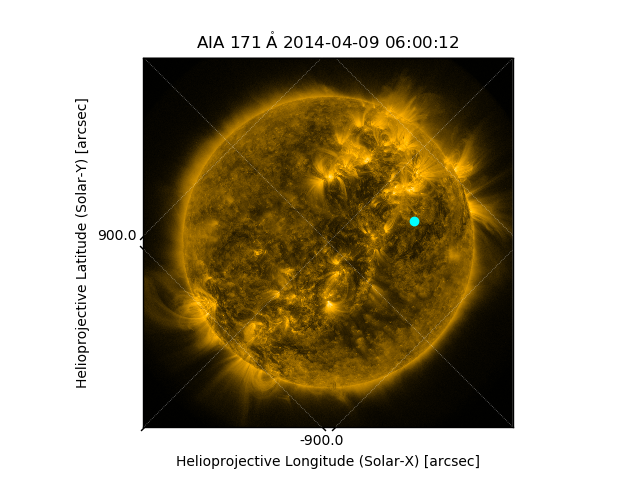

In [116]:

fid = plt.figure()

im= amap.plot()

ax = plt.gca() #gca gets current axis (finds the axis set up and does it as default setup)

ax.plot_coord(SkyCoord(500*u.arcsec,-300*u.arcsec,frame=amap.coordinate_frame),'o',color='cyan')

/Users/dannyhorta/anaconda3/lib/python3.6/site-packages/sunpy/image/transform.py:122: RuntimeWarning: Input data has been cast to float64
  warnings.warn("Input data has been cast to float64", RuntimeWarning)


<IPython.core.display.Javascript object>


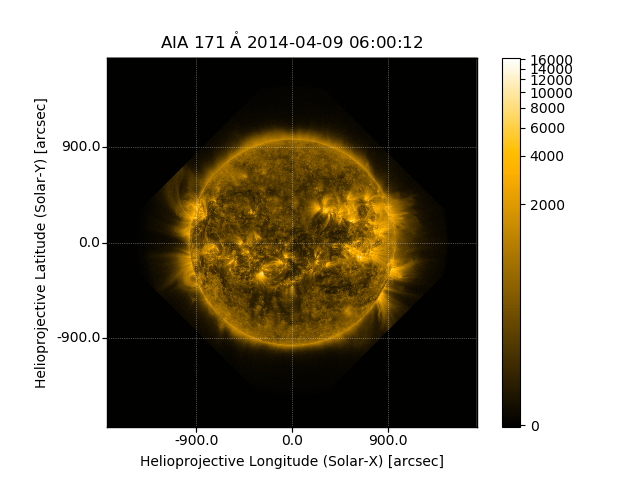

In [117]:
mr = amap.rotate(order=3)
mr.peek()